# Autoencoder


## Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install ta
!pip install arrow

  Created wheel for ta: filename=ta-0.5.20-cp36-none-any.whl size=24033 sha256=0e5320a95ed0ca9de9f4dd63413e1dcfda3285f3bc8761a34cd996a7a0d59e85
  Stored in directory: /root/.cache/pip/wheels/8a/22/4a/8c797d97dfc07b92bbe9294969ce1d55c1d4bf16e1cc2c1320
Successfully built ta
     |████████████████████████████████| 51kB 2.7MB/s 


In [0]:
import ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arrow as time
import requests as http
from tqdm import tqdm

from keras.layers.advanced_activations import PReLU
from keras.optimizers import Nadam
from keras.models import Model
from keras.layers import *
from numpy import zeros, newaxis

Using TensorFlow backend.


In [0]:
ROOT = "drive/My Drive/Colab Notebooks/Data Challenge 2/"
RANDOM_STATE = 261

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Data loading

In [0]:
%%time

xtrain = np.loadtxt(ROOT + 'data/airbus_train.csv', delimiter= ' ')
print("Train:", xtrain.shape)
xtest = np.loadtxt(ROOT + 'data/airbus_test.csv', delimiter= ' ')
print("Test:", xtest.shape)

Train: (1677, 61440)
Test: (2511, 61440)
CPU times: user 2min 53s, sys: 24.8 s, total: 3min 18s
Wall time: 3min 30s


# 2. Premier tuto 

In [0]:
xtrain2 = xtrain[:100,:32]
xtrain2.shape

(100, 32)

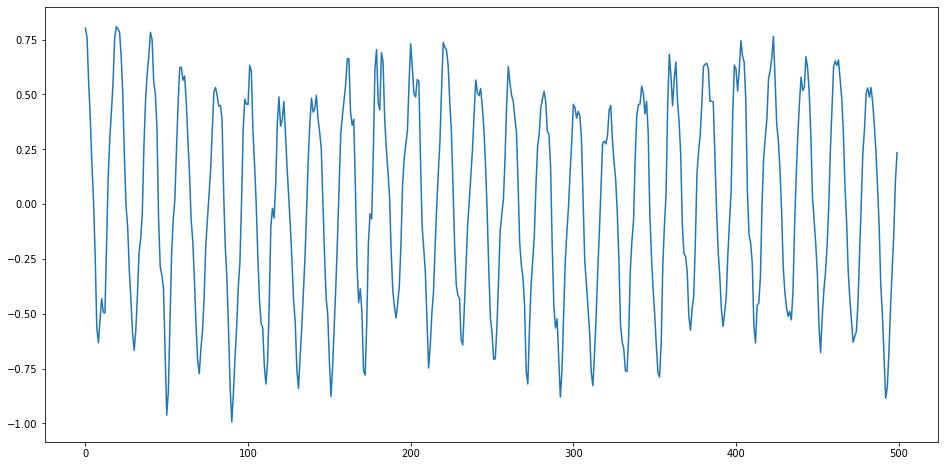

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtrain2[5,:])
plt.show()

In [0]:
xtrain2 = xtrain[:100,:32]
train_x = xtrain2.T
train_x = train_x[newaxis, :, :]
print(train_x.shape)


xtest2 = xtest[:100,:32]
test_x = xtest2.T
test_x = test_x[newaxis, :, :]
print(test_x.shape)

(1, 32, 100)
(1, 32, 100)


## Encoder and discriminator

In [0]:
def sample_normal(latent_dim, batch_size, window_size=None):
    shape = (batch_size, latent_dim) if window_size is None else (batch_size, window_size, latent_dim)
    return np.random.normal(size=shape)
  
def sample_categories(cat_dim, batch_size):
    cats = np.zeros((batch_size, cat_dim))
    for i in range(batch_size):
        one = np.random.randint(0, cat_dim)
        cats[i][one] = 1
    return cats

In [0]:
def create_encoder(latent_dim, cat_dim, window_size, input_dim):
    input_layer = Input(shape=(window_size, input_dim))
    
    code = TimeDistributed(Dense(64, activation='linear'))(input_layer)
    code = Bidirectional(LSTM(128, return_sequences=True))(code)
    code = BatchNormalization()(code)
    code = ELU()(code)
    code = Bidirectional(LSTM(64))(code)
    code = BatchNormalization()(code)
    code = ELU()(code)
    
    cat = Dense(64)(code)
    cat = BatchNormalization()(cat)
    cat = PReLU()(cat)
    cat = Dense(cat_dim, activation='softmax')(cat)
    
    latent_repr = Dense(64)(code)
    latent_repr = BatchNormalization()(latent_repr)
    latent_repr = PReLU()(latent_repr)
    latent_repr = Dense(latent_dim, activation='linear')(latent_repr)
    
    decode = Concatenate()([latent_repr, cat])
    decode = RepeatVector(window_size)(decode)
    decode = Bidirectional(LSTM(64, return_sequences=True))(decode)
    decode = ELU()(decode)
    decode = Bidirectional(LSTM(128, return_sequences=True))(decode)
    decode = ELU()(decode)
    decode = TimeDistributed(Dense(64))(decode)
    decode = ELU()(decode)
    decode = TimeDistributed(Dense(input_dim, activation='linear'))(decode)
    
    error = Subtract()([input_layer, decode])
        
    return Model(input_layer, [decode, latent_repr, cat, error])

In [0]:
def create_discriminator(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    disc = Dense(128)(input_layer)
    disc = ELU()(disc)
    disc = Dense(64)(disc)
    disc = ELU()(disc)
    disc = Dense(1, activation="sigmoid")(disc)
    
    model = Model(input_layer, disc)
    return model

## Glue the encoder and the discriminators together into the model

In [0]:
window_size = train_x.shape[1]
input_dim = train_x.shape[2]
latent_dim = 32
cat_dim = 8

prior_discriminator = create_discriminator(latent_dim)
prior_discriminator.compile(loss='binary_crossentropy', 
                            optimizer=Nadam(0.0002, 0.5), 
                            metrics=['accuracy'])

prior_discriminator.trainable = False

cat_discriminator = create_discriminator(cat_dim)
cat_discriminator.compile(loss='binary_crossentropy', 
                          optimizer=Nadam(0.0002, 0.5), 
                          metrics=['accuracy'])

cat_discriminator.trainable = False

encoder = create_encoder(latent_dim, cat_dim, window_size, input_dim)

signal_in = Input(shape=(window_size, input_dim))
reconstructed_signal, encoded_repr, category, _ = encoder(signal_in)

is_real_prior = prior_discriminator(encoded_repr)
is_real_cat = cat_discriminator(category)

autoencoder = Model(signal_in, [reconstructed_signal, is_real_prior, is_real_cat])
autoencoder.compile(loss=['mse', 'binary_crossentropy', 'binary_crossentropy'],
                                loss_weights=[0.99, 0.005, 0.005],
                                optimizer=Nadam(0.0002, 0.5))

## Training the encoder

In [0]:
batches = 10000
batch_size = 64

losses_disc = []
losses_disc_cat = []
losses_ae = []
losses_val = []

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

def discriminator_training(discriminator, real, fake):
    def train(real_samples, fake_samples):
        discriminator.trainable = True

        loss_real = discriminator.train_on_batch(real_samples, real)
        loss_fake = discriminator.train_on_batch(fake_samples, fake)
        loss = np.add(loss_real, loss_fake) * 0.5

        discriminator.trainable = False

        return loss
    return train

train_prior_discriminator = discriminator_training(prior_discriminator, real, fake)
train_cat_discriminator = discriminator_training(cat_discriminator, real, fake)

pbar = tqdm(range(batches))

for _ in pbar:
  
    ids = np.random.randint(0, train_x.shape[0], batch_size)
    signals = train_x[ids]

    _, latent_fake, category_fake, _ = encoder.predict(signals)

    latent_real = sample_normal(latent_dim, batch_size)
    category_real = sample_categories(cat_dim, batch_size)

    prior_loss = train_prior_discriminator(latent_real, latent_fake)
    cat_loss = train_cat_discriminator(category_real, category_fake)

    losses_disc.append(prior_loss)
    losses_disc_cat.append(cat_loss)

    encoder_loss = autoencoder.train_on_batch(signals, [signals, real, real])
    losses_ae.append(encoder_loss)

    val_loss = autoencoder.test_on_batch(signals, [signals, real, real])
    losses_val.append(val_loss)

    pbar.set_description("[Acc. Prior/Cat: %.2f%% / %.2f%%] [MSE train/val: %f / %f]" 
            % (100*prior_loss[1], 100*cat_loss[1], encoder_loss[1], val_loss[1]))



  0%|          | 0/10000 [00:00<?, ?it/s]

[Acc. Prior/Cat: 71.09% / 65.62%] [MSE train/val: 0.321283 / 0.321150]:   0%|          | 0/10000 [00:15<?, ?it/s]

[Acc. Prior/Cat: 71.09% / 65.62%] [MSE train/val: 0.321283 / 0.321150]:   0%|          | 1/10000 [00:15<43:05:36, 15.52s/it]

[Acc. Prior/Cat: 76.56% / 63.28%] [MSE train/val: 0.320302 / 0.320410]:   0%|          | 1/10000 [00:16<43:05:36, 15.52s/it]

[Acc. Prior/Cat: 76.56% / 63.28%] [MSE train/val: 0.320302 / 0.320410]:   0%|          | 2/10000 [00:16<30:34:53, 11.01s/it]

[Acc. Prior/Cat: 69.53% / 66.41%] [MSE train/val: 0.319493 / 0.319679]:   0%|          | 2/10000 [00:16<30:34:53, 11.01s/it]

[Acc. Prior/Cat: 69.53% / 66.41%] [MSE train/val: 0.319493 / 0.319679]:   0%|          | 3/10000 [00:16<21:49:13,  7.86s/it]

[Acc. Prior/Cat: 66.41% / 61.72%] [MSE train/val: 0.318703 / 0.318930]:   0%|          | 3/10000 [00:17<21:49:13,  7.86s/it]

[Acc. Prior/Cat: 66.41% / 61.72%] [MSE train/val: 0.318703 / 0.318930]:   0%|       

KeyboardInterrupt: ignored

ValueError: ignored

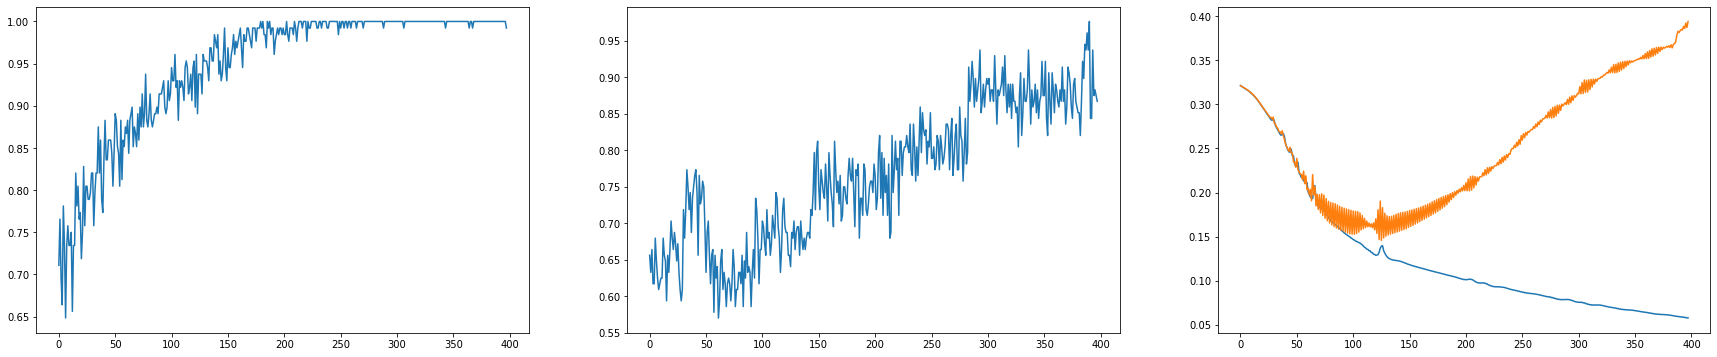

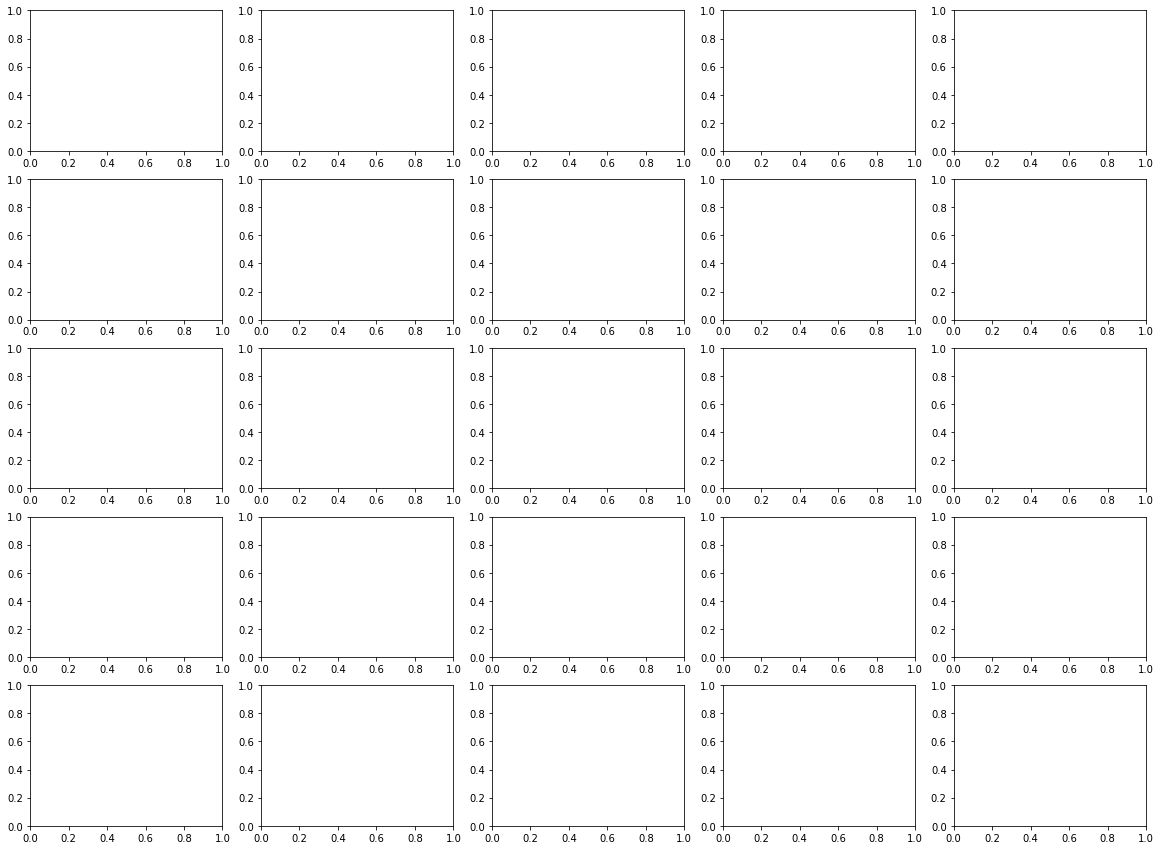

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 6)

axes[0].plot([loss[1] for loss in losses_disc])
axes[1].plot([loss[1] for loss in losses_disc_cat])
axes[2].plot([loss[1] for loss in losses_ae])
axes[2].plot([loss[1] for loss in losses_val])

fig.show()

size = 5
offset = 5

fig, axes = plt.subplots(nrows=size, ncols=5)
fig.set_size_inches(20, 3 * size)

(dec, rep, cat, error) = encoder.predict(test_x[offset:size+offset])

for i in range(size):  
    axes[i,0].plot(test_x[i+offset])
    axes[i,1].imshow(rep[i].reshape(8,4))
    axes[i,2].imshow(cat[i].reshape(cat_dim, 1))
    axes[i,3].plot(dec[i])
    axes[i,4].plot(error[i])

fig.show()

# 3. Deuxième tuto testé

https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6

## Code du tuto

In [0]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

/usr/local/lib/python3.6/dist-packages/pyod/utils/data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


In [0]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [0]:
X_train.shape

(500, 25)

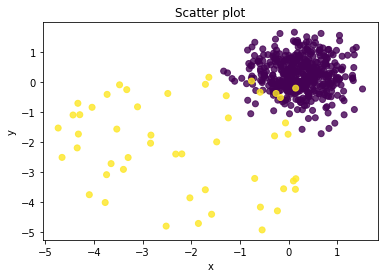

In [0]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [0]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff71cfd82f0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

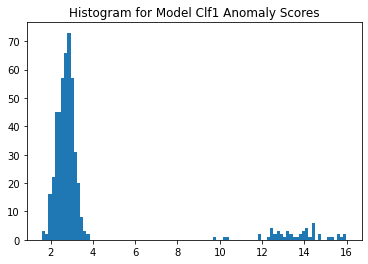

In [0]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [0]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.698710
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.547517


## Code adapté

### Préparation de données

**Moyenne mobile**

In [0]:
from scipy.signal import lfilter

n = 1000  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
mm = lfilter(b, a, xtrain[0,:])

In [0]:
xtrain_rolling = xtrain.copy()
for i in range(xtrain.shape[0]):
  xtrain_rolling[i] =  lfilter(b, a, xtrain[i,:])

In [0]:
xtest_rolling = xtest.copy()
for i in range(xtest.shape[0]):
  xtest_rolling[i] =  lfilter(b, a, xtest[i,:])

In [0]:
xtrain.shape

(1677, 61440)

**Réduction de données (rebin)**

In [0]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

xtrain_smaller = rebin(xtrain[:,:-40], (xtrain.shape[0], 614)) #xtrain[:,:-40]
print(xtrain_smaller.shape)

xtest_smaller = rebin(xtest[:,:-40], (xtest.shape[0], 614))
print(xtest_smaller.shape)

(1677, 614)
(2511, 614)


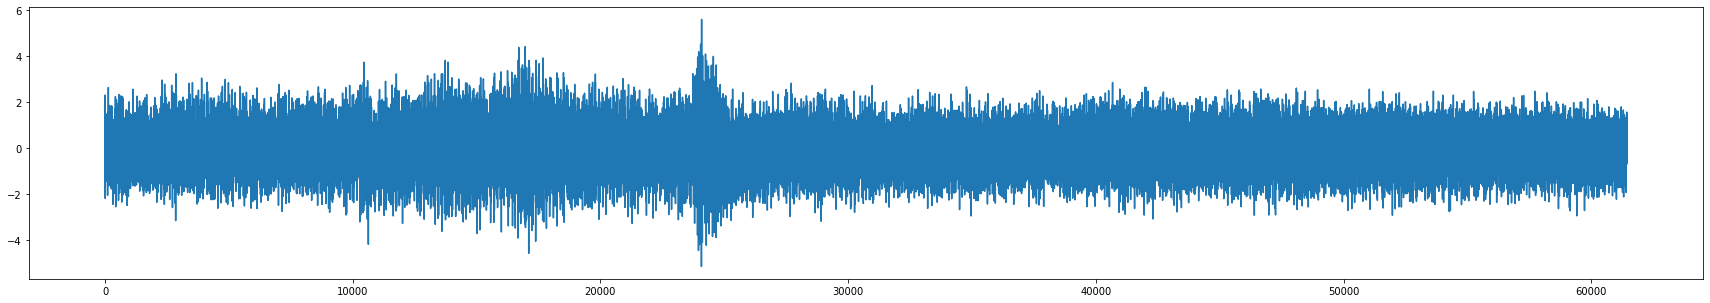

In [0]:
plt.figure(figsize=(30,5))
plt.plot(xtest[10,:]) #2125 #2275 #xtrain 5
plt.show()

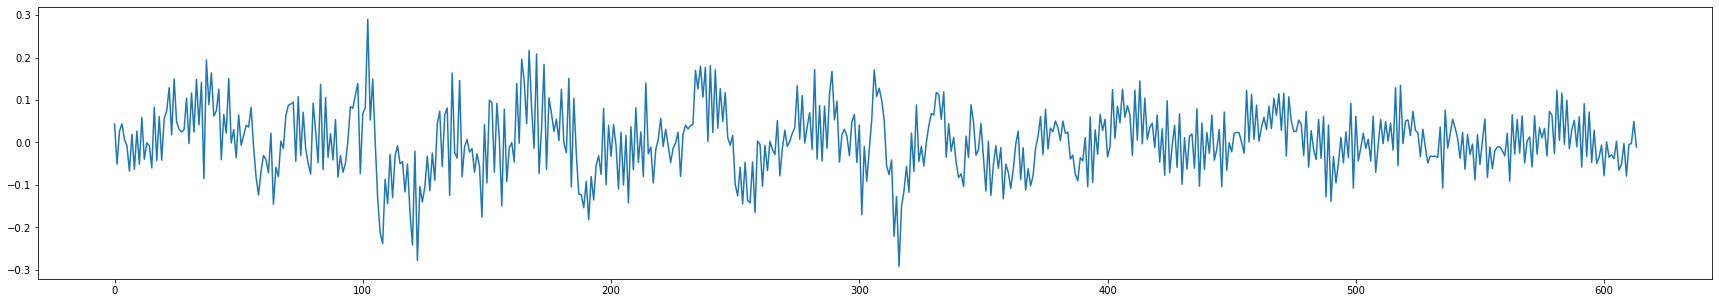

In [0]:
plt.figure(figsize=(30,5))
plt.plot(xtest_smaller[10,:])
plt.show()

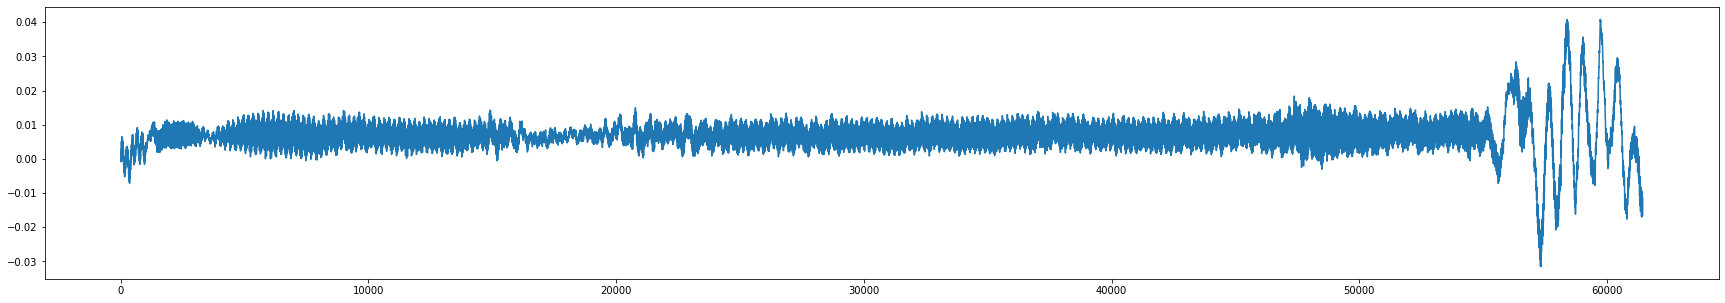

In [0]:
plt.figure(figsize=(30,5))
plt.plot(xtrain_rolling[5,:])
plt.show()

In [0]:
n_features = 6000 # Number of features

xtrain2 = xtrain[:500,:n_features]
print(xtrain2.shape)

(500, 6000)
(500, 6000)


In [0]:
xtest2 = xtest[:,:n_features]
print(xtest2.shape)

(2511, 6000)


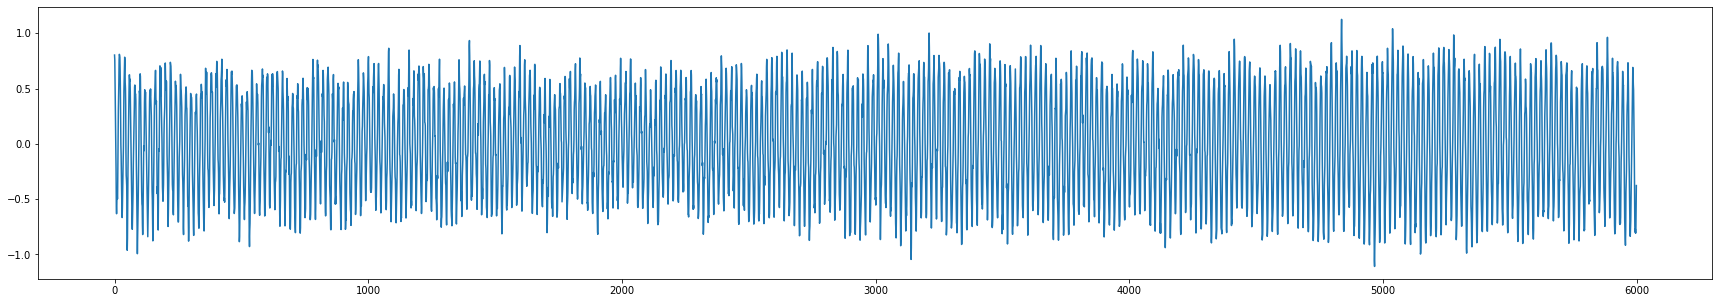

In [0]:
plt.figure(figsize=(30,5))
plt.plot(xtrain2[5,:])
plt.show()

### Autoencodeur

In [0]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

#contamination = 0.1  # percentage of outliers
#n_train = 500  # number of training points
#n_test = 500  # number of testing points
n_features = xtrain_smaller.shape[1] #6000 # Number of features


"""X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)
"""
X_train = pd.DataFrame(xtrain_smaller)
X_test = pd.DataFrame(xtest_smaller)

In [0]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [0]:
X_train.shape

(1677, 6144)

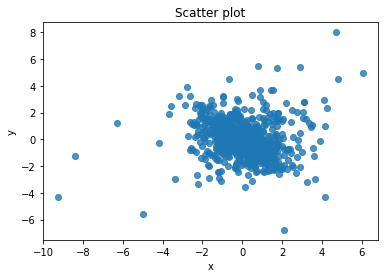

In [0]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], alpha=0.8) #c=y_train, 
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [0]:
n_features

6144

In [0]:
%%time
from pyod.models.so_gaal import SO_GAAL
clf2 = SO_GAAL()
clf2.fit(X_train)

Epoch 1 of 60

Testing for epoch 1 index 1:


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:

Testing for epoch 10 index 3:


In [0]:
%%time
neurons = [6144, 200, 100, 10, 100, 200, 6144]
clf1 = AutoEncoder(hidden_neurons = neurons, random_state = RANDOM_STATE) #, validation_size=0.3
clf1.fit(X_train)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dropout_49 (Dropout)         (None, 6144)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dropout_50 (Dropout)         (None, 6144)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dropout_51 (Dropout)         (None, 6144)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 200)              

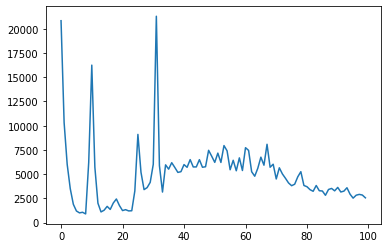

In [0]:
plt.plot(clf1.history_["loss"])
plt.show()

## LSTM 

https://towardsdatascience.com/anomaly-detection-with-lstm-in-keras-8d8d7e50ab1b

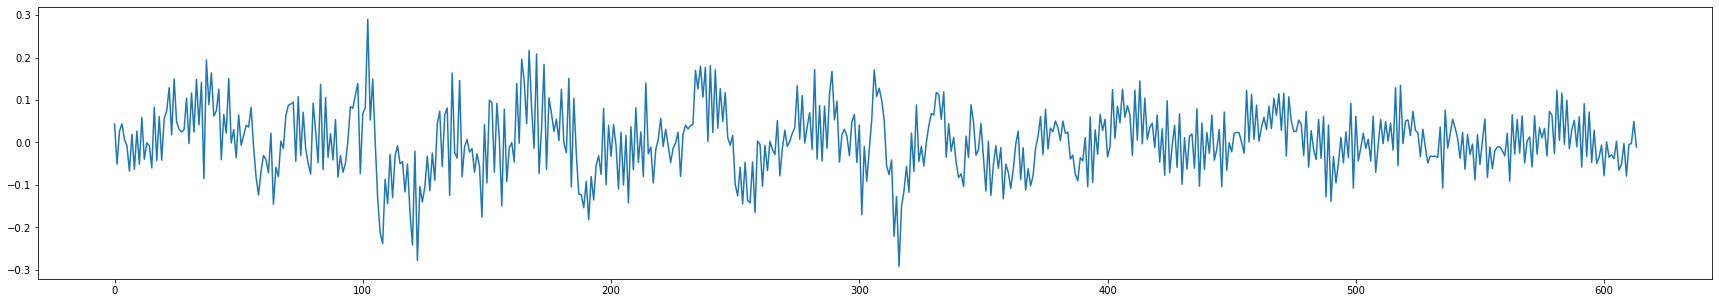

In [0]:
plt.figure(figsize=(30,5))
plt.plot(xtest_smaller[10,:])
plt.show()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import tqdm
import random
import datetime
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [0]:
inputs = Input(shape=(xtrain_smaller.shape[0], xtest_smaller.shape[1]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)
model = Model(inputs, [out10,out50,out90])

In [0]:
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]
model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [0]:
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,
                 model.layers[-2].output,
                 model.layers[-1].output])
for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

AttributeError: ignored

### Compute the score

In [0]:
# Get the outlier scores for the train data
y_train_scores = clf2.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores) #pour le clf2: y_test_scores.reshape(1,-1)[0])

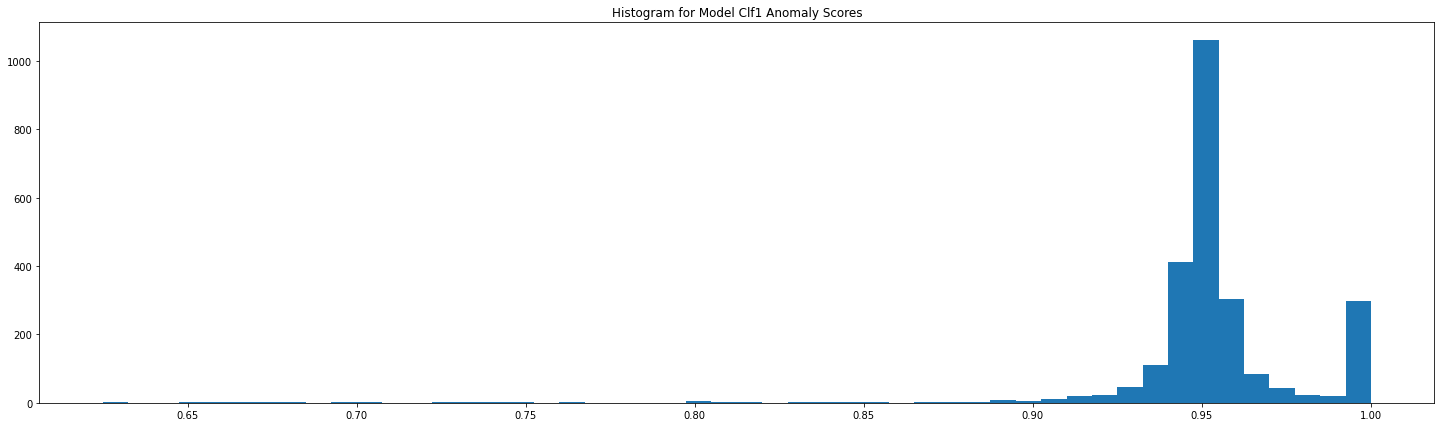

In [0]:
# Plot it!
import matplotlib.pyplot as plt
plt.figure(figsize=(25,7))
plt.hist(y_test_scores, bins=50) #'auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [0]:
y_test_scores[2275]

3.7727772173432843

In [0]:
y_test_scores

0        3.779229
1        3.178160
2        3.314049
3        3.322861
4        3.341009
          ...    
2506    99.252384
2507    68.724273
2508     3.654150
2509     3.409433
2510     1.532090
Length: 2511, dtype: float64

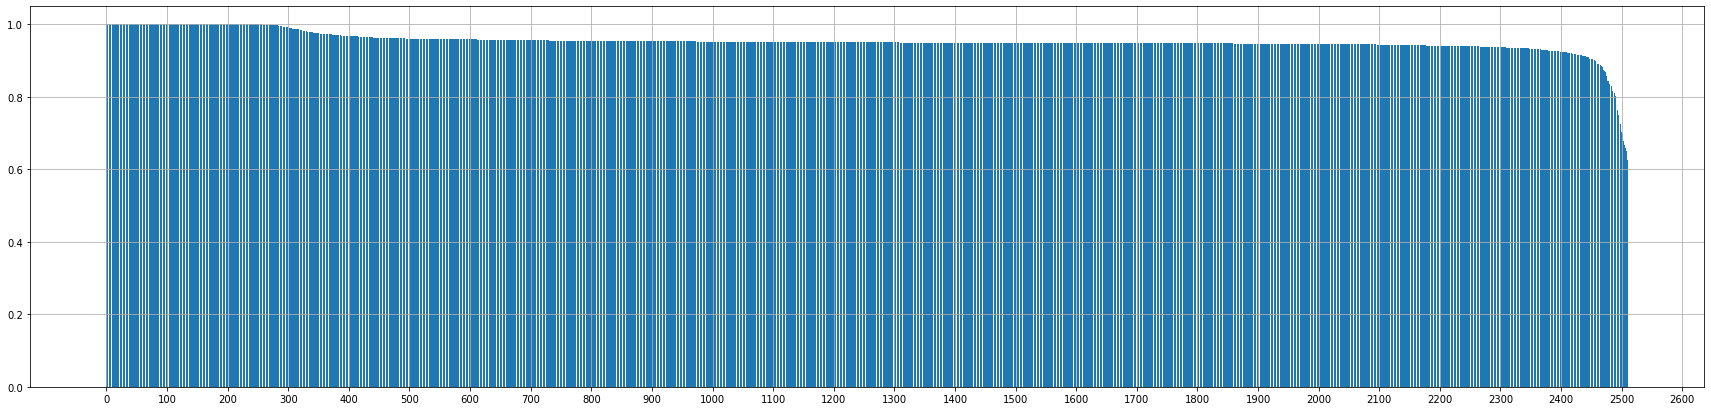

In [0]:
df_res = pd.DataFrame()
# minus signs are for sorting
df_res["index"] = np.argsort(-y_test_scores)
df_res["score"] = -np.sort(-y_test_scores)

plt.figure(figsize=(30,7))
#plt.bar(range(9, df_res.shape[0]), df_res["score"][9:])
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

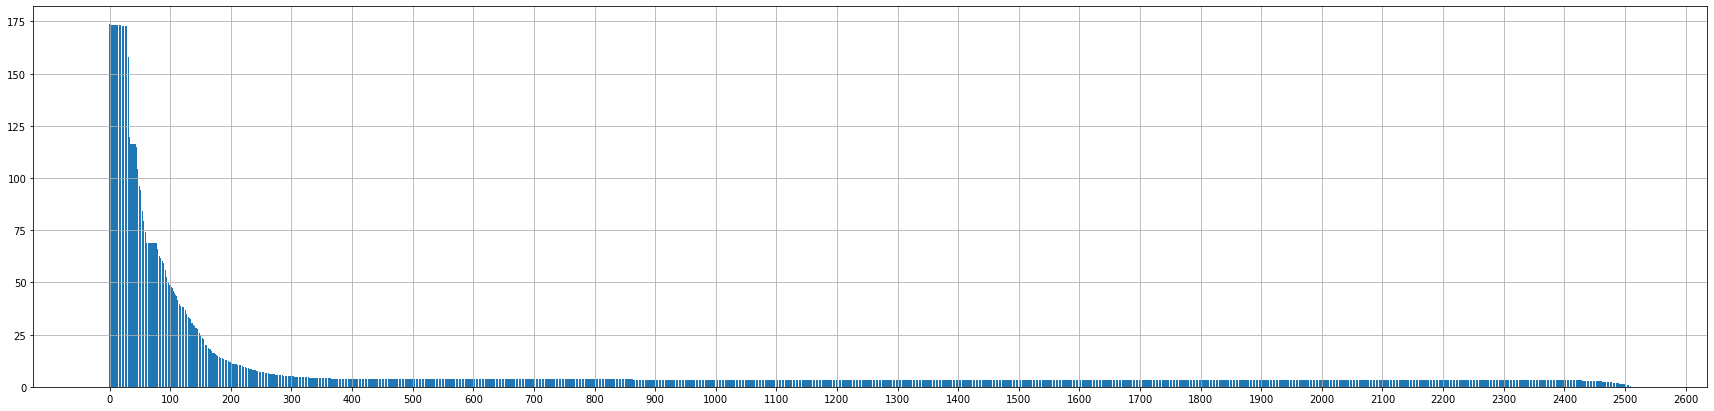

In [0]:
df_res = pd.DataFrame()
# minus signs are for sorting
df_res["index"] = np.argsort(-y_test_scores)
df_res["score"] = -np.sort(-y_test_scores)

plt.figure(figsize=(30,7))
#plt.bar(range(9, df_res.shape[0]), df_res["score"][9:])
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

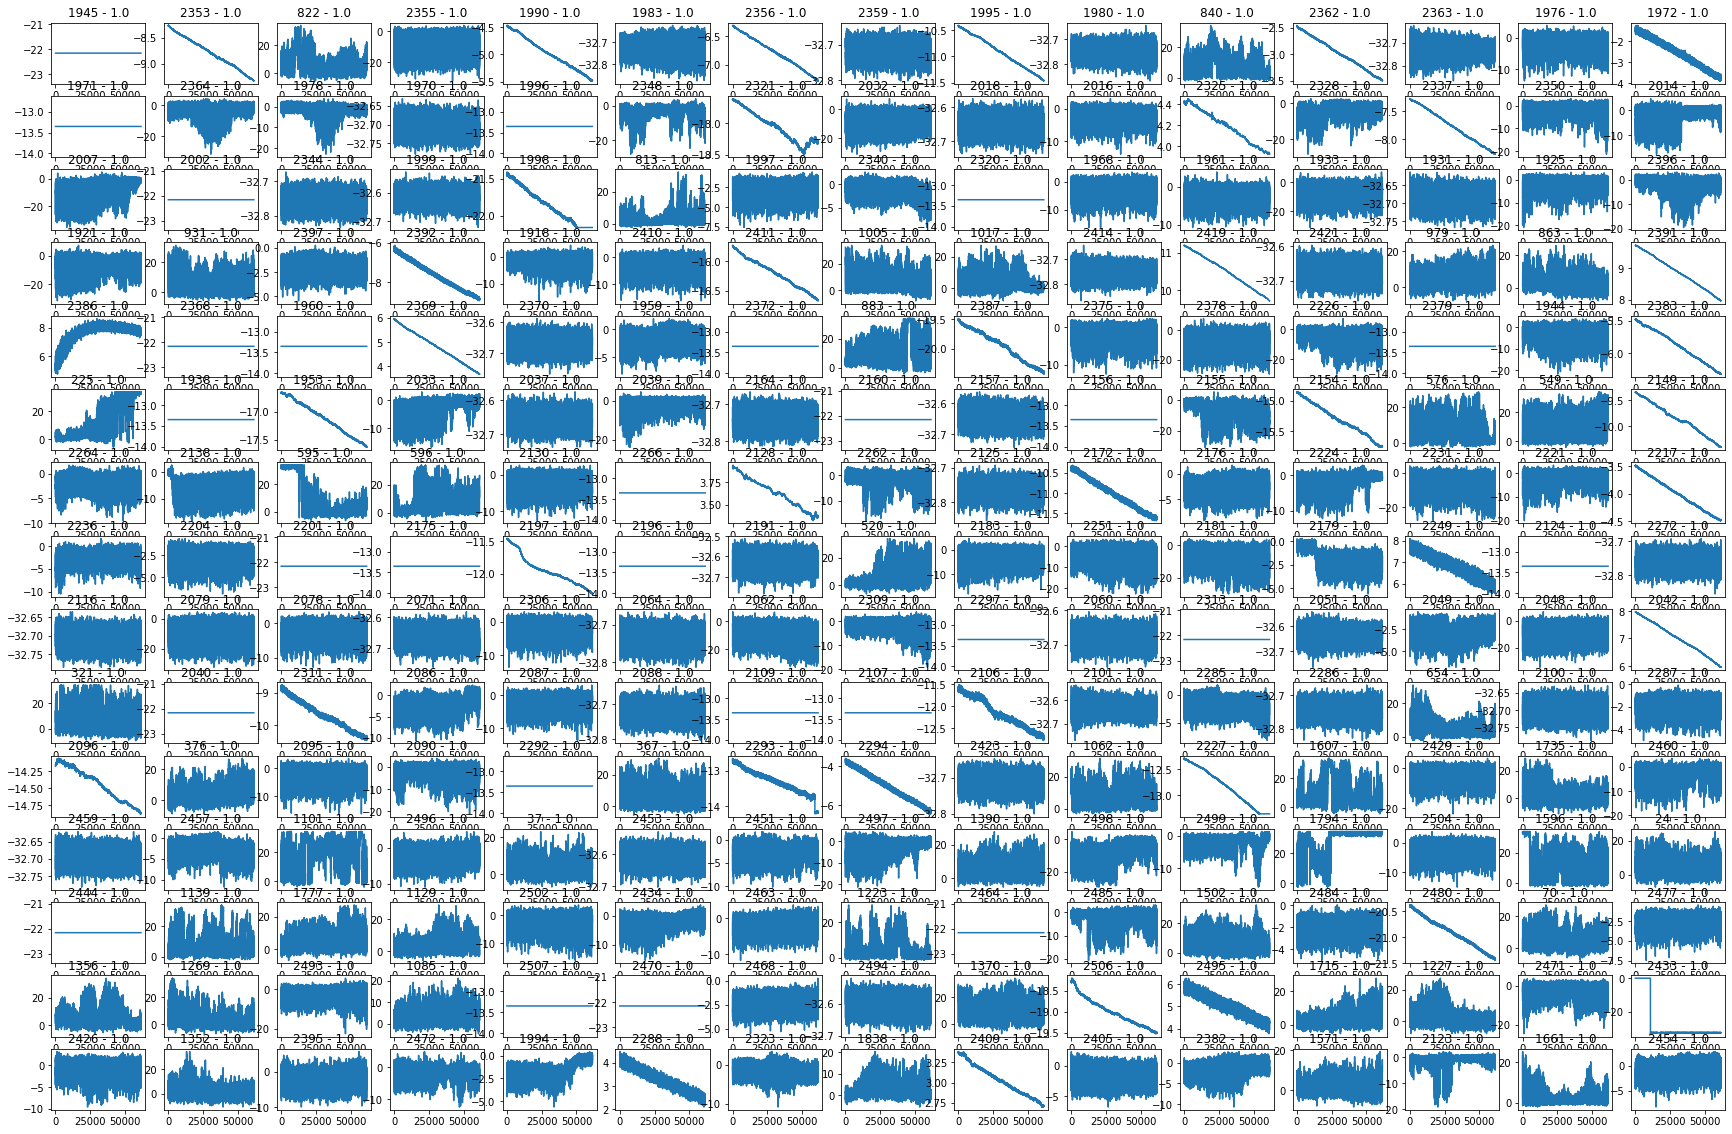

In [0]:
plt.figure(figsize=(30,20)) # x, y
for i in range(0,225):
  index = df_res["index"].iloc[i]
  plt.subplot(15,15,i+1)
  ax = plt.plot(xtest[index]) #xtest_rolling[index,1000:-1000])
  plt.title(str(index) + " - " + str(round(df_res["score"].iloc[i],4)))
plt.show()

In [0]:
print(y_test_scores.shape)
np.savetxt(ROOT + 'submissions/submission_93.csv', y_test_scores, fmt = '%1.6f', delimiter=',')

(2511,)


In [0]:
 print(neurons)
 print(X_train.shape)

[6144, 200, 100, 10, 100, 200, 6144]
(1677, 6144)


* 89: Autoencoder (hidden_neurons =[6000, 100, 2, 100, 6000]) sur xtrain [:500,:6000] (0.563356693488)
* 90: Autoencoder [614, 100, 2, 100, 614] sur xtrain (2511, 614) - 614 obtenu par réduction de données par moyennage (0.657008973266)
* 91: Autoencoder [614, 200, 100, 10, 100, 200, 614] (et validation size=0.3) sur xtrain (1677, 614) (0.65733650982)
* 92: Autoencoder [6144, 200, 100, 10, 100, 200, 6144] sur xtrain (1677, 6144) (0.558814441272)
* 93: SO_GAAL (paramètres par défaut) sur xtrain (1677, 6144) (0.666723831065)
